# Lecture 7 Demonstration

In this demonstration, we will look at a simplified regression problem, fit a random forest model and then see what we can do with the fact that some samples don't end up used in each individual tree.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Setting a random seed lets us exactly replicate our results from one run to another.
np.random.seed(333)

$$
x_1 \sim Unif(-5, 5) \\
x_2 \sim Unif(-5, 5) \\
r = \sqrt{x_1^2 + x_2^2}\\
\epsilon \sim N(0,1)\\
y = 20 \cdot \cos(r) \cdot \exp\left\{-\frac{r}{8}\right\} + \epsilon
$$

In [2]:
def noiseless(x1, x2):
    radius = np.sqrt(np.power(x1, 2) + np.power(x2, 2))
    return 20 * np.cos(radius) * np.exp(-radius / 8)

def dgp(n):
    x1 = np.random.uniform(low=-5, high=5, size = n)
    x2 = np.random.uniform(low=-5, high=5, size = n)
    y = noiseless(x1, x2) + np.random.normal(scale = 1, size = n)
    return np.hstack((x1.reshape(-1, 1), x2.reshape(-1, 1))), y



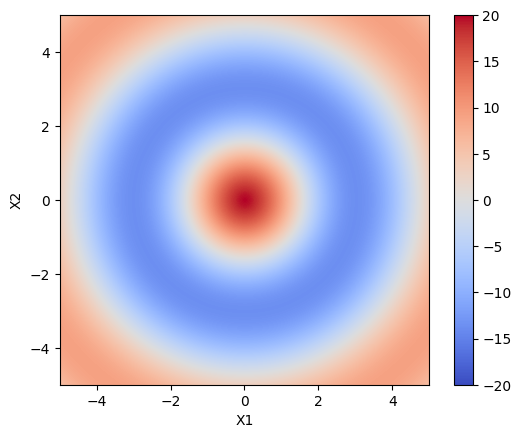

In [3]:
x1_grid = np.linspace(-5, 5, 1000)
x2_grid = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(x1_grid, x2_grid)
Z = noiseless(X, Y)

plt.imshow(Z, extent=[-5,5, -5,5], cmap=cm.coolwarm, vmin=-20, vmax=20)
plt.colorbar()
plt.xlabel("X1")
plt.ylabel("X2");

In [4]:
X, y = dgp(n = 1000)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [6]:
rf = RandomForestRegressor(n_estimators = 1)

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1)

In [7]:
n_leaves = len(set(rf.apply(X_train).ravel()))
print(f"Number of terminal leaves: {n_leaves}")

Number of terminal leaves: 429


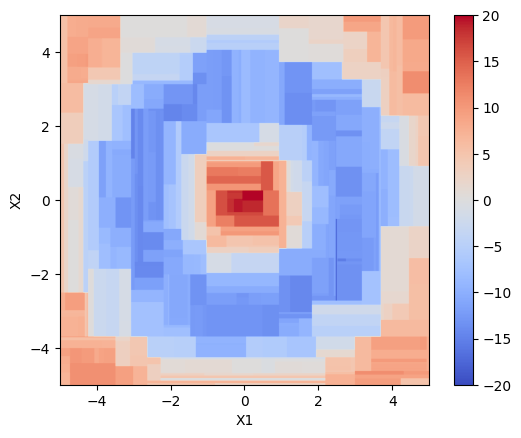

In [8]:
x1_grid = np.linspace(-5, 5, 1000)
x2_grid = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(x1_grid, x2_grid)

Z = rf.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.imshow(Z, extent=[-5,5, -5,5], cmap=cm.coolwarm, vmin=-20, vmax=20)
plt.colorbar()
plt.xlabel("X1")
plt.ylabel("X2");

In [9]:
rf = RandomForestRegressor(n_estimators = 1000, oob_score = mean_squared_error)

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000,
                      oob_score=<function mean_squared_error at 0x12fb72520>)

In [10]:
yhat_train = rf.predict(X_train)
yhat_test = rf.predict(X_test)

mse = mean_squared_error(y_test, yhat_test)
# We can also retrieve an estimate of our estimate's variability using
se = np.std(np.power(y_test - yhat_test, 2)) / np.sqrt(y_test.shape[0])

mse_train = mean_squared_error(y_train, yhat_train)

In [11]:
print(f"The MSE is: {mse:04.3f}, in [{mse - 1.96 * se:04.3f}, {mse + 1.96 * se:04.3f}]")
print(f"The in-sample MSE is: {mse_train:04.3f}")
print(f"The OOB estimate is: {rf.oob_score_:04.3f}")

The MSE is: 2.416, in [1.945, 2.886]
The in-sample MSE is: 0.372
The OOB estimate is: 2.714


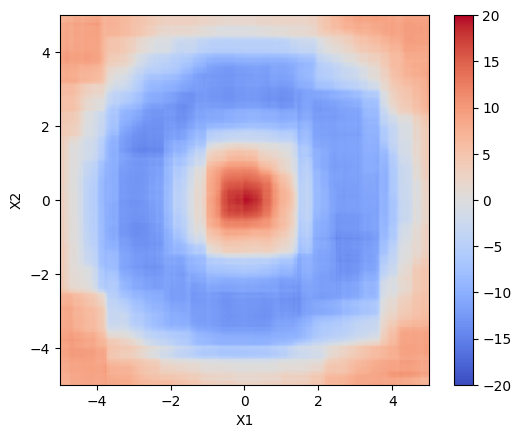

In [12]:
x1_grid = np.linspace(-5, 5, 1000)
x2_grid = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(x1_grid, x2_grid)

Z = rf.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.imshow(Z, extent=[-5,5, -5,5], cmap=cm.coolwarm, vmin=-20, vmax=20)
plt.colorbar()
plt.xlabel("X1")
plt.ylabel("X2");

To determine which observations are in which tree, we can use the `estimators_samples_` property of the `RandomForestRegressor` object. This would let us see, for example, how many times unit `i` appears in decision tree `j`.

In [13]:
samples = rf.estimators_samples_

In [14]:
samples = np.array(samples)

In [15]:
samples.shape

(1000, 700)

In [16]:
n_train = X_train.shape[0]
M = rf.n_estimators
x = np.array([[-2, -2]])
f_x = rf.predict(x)

fm_x = np.array([dt.predict(x) for dt in rf.estimators_]).reshape(-1)
for i in range(n_train):
    n_im = (samples == i).sum(axis=1) # Samples of each training point in each estimator
    cov_i = np.power(np.cov(n_im, fm_x), 2) # squared covariance between samples and estimates
se_x = np.sqrt(np.sum(cov_i) - n_train / np.power(M, 2) * np.sum(np.power(fm_x - f_x, 2)))

In [17]:
print(f"The prediction of [-2,-2] is {f_x.item():04.3f} with s.e. of {se_x:04.3f}")

The prediction of [-2,-2] is -12.289 with s.e. of 4.900


In [18]:
def se_infinitesimal_jackknife(model, X):
    samples = np.array(model.estimators_samples_)
    n_train = samples.shape[1]
    n_test = X.shape[0]
    M = model.n_estimators

    f_x = model.predict(X)
    se_x = np.ones(n_test)
    fm_x = np.array([dt.predict(X) for dt in rf.estimators_])

    n_im = np.ones((M, n_train))
    for i in range(n_train):
        n_im[:, i] = (samples == i).sum(axis=1) # Samples of each training point in each estimator
    for j in range(n_test):
        for i in range(n_train):
            # Note that we pull out single columns from n_im and fm_x
            # This is fast because numpy is column-major ordering.
            cov_i2 = np.power(np.cov(n_im[:, i], fm_x[:, j]), 2) # squared covariance between samples and estimates
        se_x[j] = np.sqrt(np.sum(cov_i2) - n_train / np.power(M, 2) * np.sum(np.power(fm_x[:, j] - f_x[j], 2)))
    return f_x, se_x

In [19]:
yhat_test, se_test = se_infinitesimal_jackknife(rf, X_test)

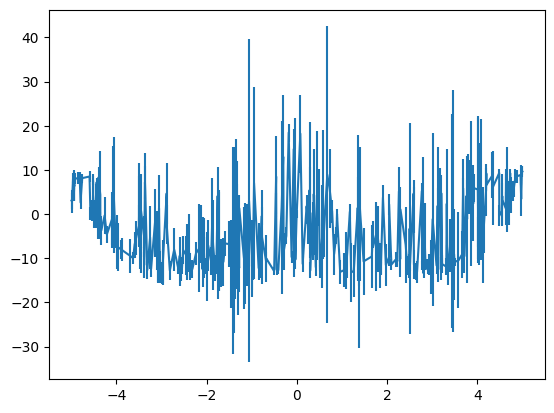

In [20]:
x1_test = X_test[:,0]
ord = np.argsort(x1_test)

plt.errorbar(x1_test[ord], yhat_test[ord], se_test[ord]);

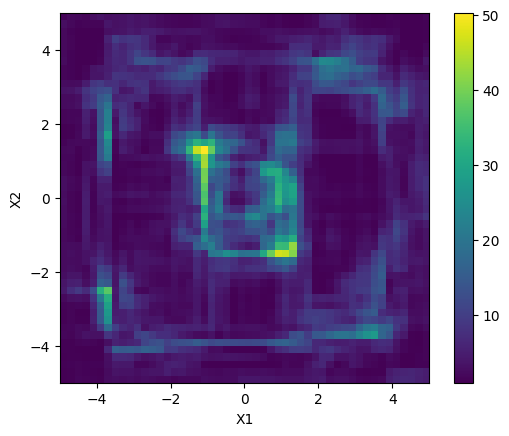

In [21]:
x1_grid = np.linspace(-5, 5, 50)
x2_grid = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x1_grid, x2_grid)

yhat, se = se_infinitesimal_jackknife(rf, np.c_[X.ravel(), Y.ravel()])
Z = se.reshape(X.shape)

plt.imshow(Z, extent=[-5,5, -5,5], cmap=cm.viridis)
plt.colorbar()
plt.xlabel("X1")
plt.ylabel("X2");

In [22]:
pred_x = np.array([dt.predict(X_test) for dt in rf.estimators_])

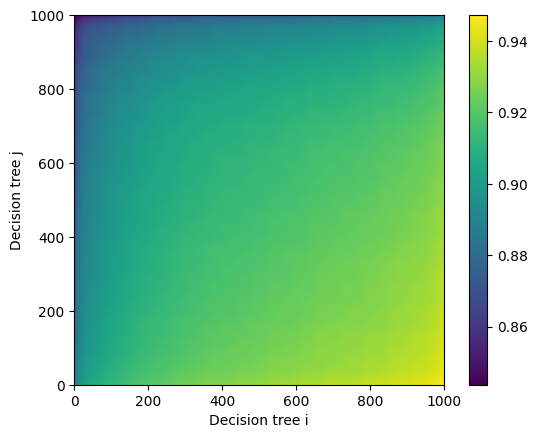

In [23]:
from scipy.ndimage import gaussian_filter
res_cor = np.corrcoef(pred_x)
sum_cor = np.power(res_cor, 2).sum(axis=1)
for i in range(res_cor.shape[1]):
    res_cor[i,i] = np.average(res_cor[i,:]) # smooth over diagonals for a cleaner plot

ord = np.argsort(sum_cor)
res_cor = res_cor[ord, :][:, ord]
M = res_cor.shape[1]
plt.imshow(gaussian_filter(res_cor, sigma=10), extent=[0, M, 0, M], cmap=cm.viridis)
plt.colorbar()
plt.xlabel("Decision tree i")
plt.ylabel("Decision tree j");

In [24]:
fm_x = np.array([y_train - dt.predict(X_train) for dt in rf.estimators_])
res_cor = np.corrcoef(fm_x)
sum_cor = np.power(res_cor, 2).sum(axis=1)
weight = 1 / sum_cor
weight = weight / np.sum(weight)

fm_x = np.array([w * dt.predict(X_test) for w, dt in zip(weight, rf.estimators_)])
f_x_weighted = fm_x.sum(axis=0)
f_x_unweighted = rf.predict(X_test)

mse_weighted = np.average(np.power(f_x_weighted - y_test, 2))
se_weighted = np.std(np.power(f_x_weighted - y_test, 2)) / np.sqrt(y_test.shape[0])
mse_unweighted = np.average(np.power(f_x_unweighted - y_test, 2))
se_unweighted = np.std(np.power(f_x_unweighted - y_test, 2)) / np.sqrt(y_test.shape[0])

print(f"The average of the unweighted MSE is: {mse_unweighted:04.3f}, in [{mse_unweighted - 1.96 * se_unweighted:04.3f}, {mse_unweighted + 1.96 * se_unweighted:04.3f}]")
print(f"The average of the weighted MSE is: {mse_weighted:04.3f}, in [{mse_weighted - 1.96 * se_weighted:04.3f}, {mse_weighted + 1.96 * se_weighted:04.3f}]")

The average of the unweighted MSE is: 2.416, in [1.945, 2.886]
The average of the weighted MSE is: 2.378, in [1.915, 2.840]


In [25]:
from sklearn.ensemble import GradientBoostingRegressor

gbdt = GradientBoostingRegressor(n_estimators = 100)
gbdt.fit(X_train, y_train)

GradientBoostingRegressor()

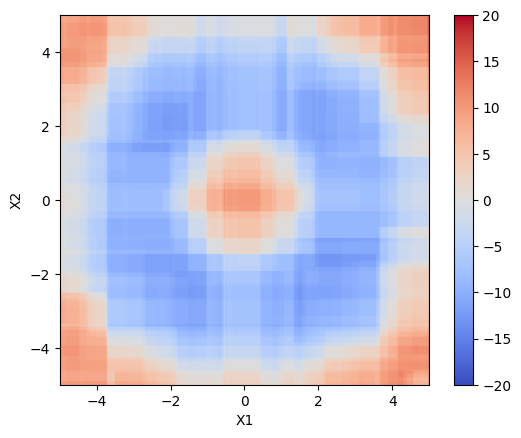

In [26]:
x1_grid = np.linspace(-5, 5, 1000)
x2_grid = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(x1_grid, x2_grid)

Z = gbdt.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)

plt.imshow(Z, extent=[-5,5, -5,5], cmap=cm.coolwarm, vmin=-20, vmax=20)
plt.colorbar()
plt.xlabel("X1")
plt.ylabel("X2");

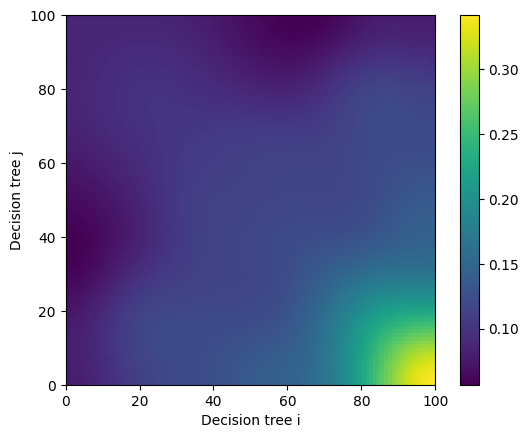

In [27]:
pred_x = np.array([dt.predict(X_test) for dt in gbdt.estimators_.ravel()])

res_cor = np.corrcoef(pred_x)
sum_cor = np.power(res_cor, 2).sum(axis=1)
for i in range(res_cor.shape[1]):
    res_cor[i,i] = np.average(res_cor[i,:]) # smooth over diagonals for a cleaner plot

ord = np.argsort(sum_cor)
res_cor = res_cor[ord, :][:, ord]
M = res_cor.shape[1]
plt.imshow(gaussian_filter(res_cor, sigma=10), extent=[0, M, 0, M], cmap=cm.viridis)
plt.colorbar()
plt.xlabel("Decision tree i")
plt.ylabel("Decision tree j");